In [1]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, isdir, join, splitext
import pandas as pd
import scipy.io
from scipy.signal import savgol_filter
from scipy import stats
import seaborn as sns

In [2]:
def is_point_within_radius(point, target, radius):
    dist2 = (target[0] - point[0])**2 + (target[1] - point[1])**2
    if dist2 <= radius**2:
        return True
    return False

def grid_points_within_radius(center, radius, grid_steps):
    support = np.linspace(1/(grid_steps+1), 1 - 1/(grid_steps+1), grid_steps)
    points = []
    
    # The rows count down since the origin is now in the bottom left 
    # instead of the top left
    for c in range(grid_steps):
        for r in range(grid_steps):
            dist2 = (center[0] - support[c])**2 + (center[1] - support[-r-1])**2
            if dist2 < radius**2:
                points.append((c, grid_steps-r-1))
    return [grid_steps*c + r for (c, r) in points]


In [5]:
global_min_locs = {
    "ackley": (0.5000,    0.5000),
    "ackley2": (0.5000, 0.5000),
    "alpine1": (0.5000,    0.5000),
    "alpine2": (0.7917,    0.7917),
    "bohachevsky2": (0.5000,    0.5000),
    "camel3": (0.5000,    0.5000),
    "csendes": (0.5000,    0.5000),
    "defl_corr_spring": (0.5000,    0.5000),
    "dropwave": (0.5000,    0.5000),
    "easom": (0.5000,    0.5000),
    "griewank": (0.5000,    0.5000),
    "holder": (0.8055,    0.9665),
    "hosaki": (0.8000,    0.4000),
    "levy": (0.5500,    0.5500),
    "levy13": (0.5500,    0.5500),
    "michalewicz": (0.7003,    0.4997),
    "rastrigin": (0.5000,    0.5000),
    "rosenbrock": (0.8333,    0.8333),
    "shubert": (0.3214,    0.7713),
    "styblinski_tang": (0.2097,    0.2097),
    "sumofsquares": (0.5000, 0.5000),
    "xinsheyang3": (0.5000, 0.5000)
}

dirs = list(global_min_locs.keys())
DATA_DIR = "/Users/ethan/LocalResearchData/HamiltonianDescent"
NCVX_DATA_DIR = DATA_DIR + "/nonconvex2DSGD"
IPOPT_DATA_DIR = DATA_DIR + "/NonconvexExperiments/IPOPT2D"
FMINCON_DATA_DIR = DATA_DIR + "/NonconvexExperiments/fmincon2D"



# Table: Success Probability

In [6]:
# LOAD success prob data

data = {
    "SGD": {},
    "NAGD4": {},
    "IPOPT": {},
    "MATLAB": {},
    "QAA": {},
    "QHD": {}
}

prob_data = {
    "SGD": [],
    "NAGD4": [],
    "IPOPT": [],
    "MATLAB": [],
    "QAA": [],
    "QHD": []
}


NUM_SHOTS = 1000

radius = 0.1
steps = 256
adb_steps = 64

for d in dirs:
    if not isdir(join(NCVX_DATA_DIR, d)):
        print(f"The data path for function {d} is not found.")
    else:
        if d == "bird":
            # Omitting the bird function because it has two global minima
            continue
        print(d)
        scipy.io.loadmat(join(NCVX_DATA_DIR, d, f"{d}_NGD.mat"), mdict=data["SGD"])
        scipy.io.loadmat(join(NCVX_DATA_DIR, d, f"{d}_NESTEROV4.mat"), mdict=data["NAGD4"])
        
        if not d == "alpine1":
            scipy.io.loadmat(join(IPOPT_DATA_DIR, f"{d}_IPOPTData.mat"), mdict=data["IPOPT"])
        
        scipy.io.loadmat(join(FMINCON_DATA_DIR, f"{d}_fminconData.mat"), mdict=data["MATLAB"])
        
        adb_filename = f"{d}_QAA_T500.mat"
        adb_f = h5py.File(join(NCVX_DATA_DIR, d, adb_filename), 'r')
        for k, v in adb_f.items():
            data["QAA"][k] = np.array(adb_f.get(k))
                    
        qhd_wfn_dir = f"{d}_QHD_WFN"
        data["QHD"]["wfn"] = np.load(os.path.join(NCVX_DATA_DIR, d, qhd_wfn_dir, "psi_5000e-01.npy"))
        

####### # SGD
        counter = 0
        for i in range(NUM_SHOTS):
            last_idx = data["SGD"]["ngd_last_frame"][i] - 1
            point = data["SGD"]["ngd_positions"][i, last_idx, :][0]
            
            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1
                
        prob_data["SGD"].append(counter / NUM_SHOTS)

####### # NESTEROV using 1e-4
        counter = 0
        for i in range(NUM_SHOTS):
            last_idx = data["NAGD4"]["nesterov_last_frame"][i] - 1
            point = data["NAGD4"]["nesterov_positions"][i, last_idx, :][0]
                    
            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1
        
        prob_data["NAGD4"].append(counter / NUM_SHOTS)

####### # IPOPT
        if d == "alpine1":
            prob_data["IPOPT"].append(float("nan"))
        else:
            counter = 0
        
            for i in range(NUM_SHOTS):
                point = data["IPOPT"]["end_points"][:, i]
                if is_point_within_radius(point, global_min_locs[d], radius):
                    counter += 1
            
            prob_data["IPOPT"].append(counter / NUM_SHOTS)

####### # MATLAB FMINCON
        counter = 0
        for i in range(NUM_SHOTS):
            point = data["MATLAB"]["end_points"][:, i]
            if is_point_within_radius(point, global_min_locs[d], radius):
                counter += 1
        
        prob_data["MATLAB"].append(counter / NUM_SHOTS)
        
####### # QUANTUM ADIABATIC
        x_adb_data = data["QAA"]["snapshot_times"][0]
        adb_wfn = data["QAA"]["wfn"].view(np.complex128)
        adb_num_frames = len(x_adb_data)
        adb_nbhd_prob = np.empty(adb_num_frames)
        adb_nbhd_idcs = grid_points_within_radius(global_min_locs[d], radius, adb_steps)
        adb_frame = adb_wfn[:,-1]
        adb_nbhd_amps = adb_frame[adb_nbhd_idcs]
        adb_prob = np.sum((adb_nbhd_amps * np.conj(adb_nbhd_amps)).real)
        prob_data["QAA"].append(adb_prob)
        
####### # QUANTUM HAMILTONIAN DESCENT
        nbhd_idcs = grid_points_within_radius(global_min_locs[d], radius, steps)
        nbhd_locs = np.zeros((steps * steps,1))
        nbhd_locs[nbhd_idcs] = 1
        nbhd_locs = np.reshape(nbhd_locs, (steps,steps), order='F')

        psi = data["QHD"]["wfn"]
        qhd_prob = (nbhd_locs * ((psi * psi.conj()).real)).sum()
        prob_data["QHD"].append(qhd_prob)
        

ackley
ackley2
alpine1
alpine2
bohachevsky2
camel3
csendes
defl_corr_spring
dropwave
easom
griewank
holder
hosaki
levy
levy13
michalewicz
rastrigin
rosenbrock
shubert
styblinski_tang
sumofsquares
xinsheyang3


In [7]:
# STORE data in pd dataframe

pd.set_option("display.precision", 3)

prob_df = pd.DataFrame({
    "SGD": prob_data["SGD"],
    "NAGD": prob_data["NAGD4"],
    "IPOPT": prob_data["IPOPT"],
    "MATLAB": prob_data["MATLAB"],
    "QAA": prob_data["QAA"],
    "QHD": prob_data["QHD"]},
    index=dirs
)

In [8]:
# GENERATE SUCCESS PROBABILITY TABLE from dataframe

def highlight_top_k(s, k=1, cmap=[("black", "[HTML]{EEEEEE}")]):
    unsortedvals = [v for v in s.values if not np.isnan(v)]
    topk = sorted(unsortedvals, reverse=True)[:k]
    topk_vals = sorted(list(set(topk)), reverse=True)
    
    props = s.shape[0] * ['']
    
    for top_idx in range(len(topk_vals)):
        val = topk_vals[top_idx]
        text_color = cmap[top_idx][0]
        bg_color = cmap[top_idx][1]
        for c_idx in range(len(s.values)):
            if np.allclose(s.values[c_idx], val, atol=1e-3):
                props[c_idx] = f'color:{{{text_color}}}; cellcolor:{bg_color}; bfseries:'
    return np.array(props, dtype=object)
   
    
def relabel_data(val):
    if val > 0.999 and val < 1:
        return "$>$0.999"
    return format(round(val, 3), ".3f")

def relabel_index_headers(val):
    return val


colored_table = prob_df.style.apply(highlight_top_k, axis=1).export()

print(prob_df.rename(lambda idx: idx.replace('_',' ')).style.format(relabel_data).use(colored_table).to_latex(column_format="l|cccccc"))
# print(prob_df.rename(lambda idx: idx.replace('_',' ')).to_markdown(tablefmt="grid"))

\begin{tabular}{l|cccccc}
 & SGD & NAGD & IPOPT & MATLAB & QAA & QHD \\
ackley & 0.471 & 0.033 & 0.304 & 0.155 & 0.265 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries 0.895 \\
ackley2 & 0.961 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries 1.000 & 0.885 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries 1.000 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries $>$0.999 & 0.529 \\
alpine1 & 0.047 & 0.044 & nan & 0.173 & 0.296 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries 0.998 \\
alpine2 & 0.188 & 0.187 & 0.160 & 0.120 & 0.984 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries 0.997 \\
bohachevsky2 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries 1.000 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries 0.999 & 0.990 & 0.993 & 0.967 & 0.999 \\
camel3 & 0.599 & 0.601 & 0.800 & 0.624 & 0.441 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries 0.992 \\
csendes & 0.166 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries 1.000 & \color{black} \cellcolor[HTML]{EEEEEE} \bfseries 1.000

In [9]:
# DEFINE THE CLASSES OF THE 2D FUNCTIONS
features = {
    "Ridges and Valleys": [
        "dropwave", 
        "levy", 
        "levy13",
        "holder", 
        "ackley2"
    ],
    "Basins": [
        "bohachevsky2",
        "rosenbrock",
        "camel3",
        "csendes",
        "defl_corr_spring"
    ],
    "Flat": [
        "michalewicz",
        "easom",
        "xinsheyang3"
    ],
    "Studded": [
        "alpine1",
        "griewank",
        "ackley",
        "rastrigin"
    ],
    "Simple": [
        "alpine2",
        "hosaki",
        "shubert",
        "styblinski_tang",
        "sumofsquares"
    ]
}

features = {
    "Ridges and Valleys": [
        "ackley2",
        "holder", 
        "levy13",
        "levy", 
        "dropwave", 
    ],
    "Basins": [
        "defl_corr_spring",
        "csendes",
        "camel3",
        "rosenbrock",
        "bohachevsky2",
    ],
    "Flat": [
        "xinsheyang3",
        "easom",
        "michalewicz",
    ],
    "Studded": [
        "rastrigin",
        "ackley",
        "griewank",
        "alpine1",
    ],
    "Simple": [
        "sumofsquares",
        "styblinski_tang",
        "hosaki",
        "shubert",
        "alpine2",
    ]
}

fname_to_label = {
    "dropwave": "Drop-Wave",
    "levy": "Levy",
    "levy13": "Levy 13",
    "holder": "Holder Table",
    "ackley2": "Ackley 2",
    "bohachevsky2": "Bohachevsky 2",
    "rosenbrock": "Rosenbrock",
    "camel3": "Camel 3",
    "csendes": "Csendes",
    "defl_corr_spring": "Defl. Corr. Spring",
    "michalewicz": "Michalewicz",
    "easom": "Easom",
    "xinsheyang3": "Xin-She Yang 3",
    "alpine1": "Alpine 1",
    "griewank": "Griewank",
    "ackley": "Ackley",
    "rastrigin": "Rastrigin",
    "alpine2": "Alpine 2",
    "hosaki": "Hosaki",
    "shubert": "Shubert",
    "styblinski_tang": "Styblinski-Tang",
    "sumofsquares": "Sum of Squares"
}

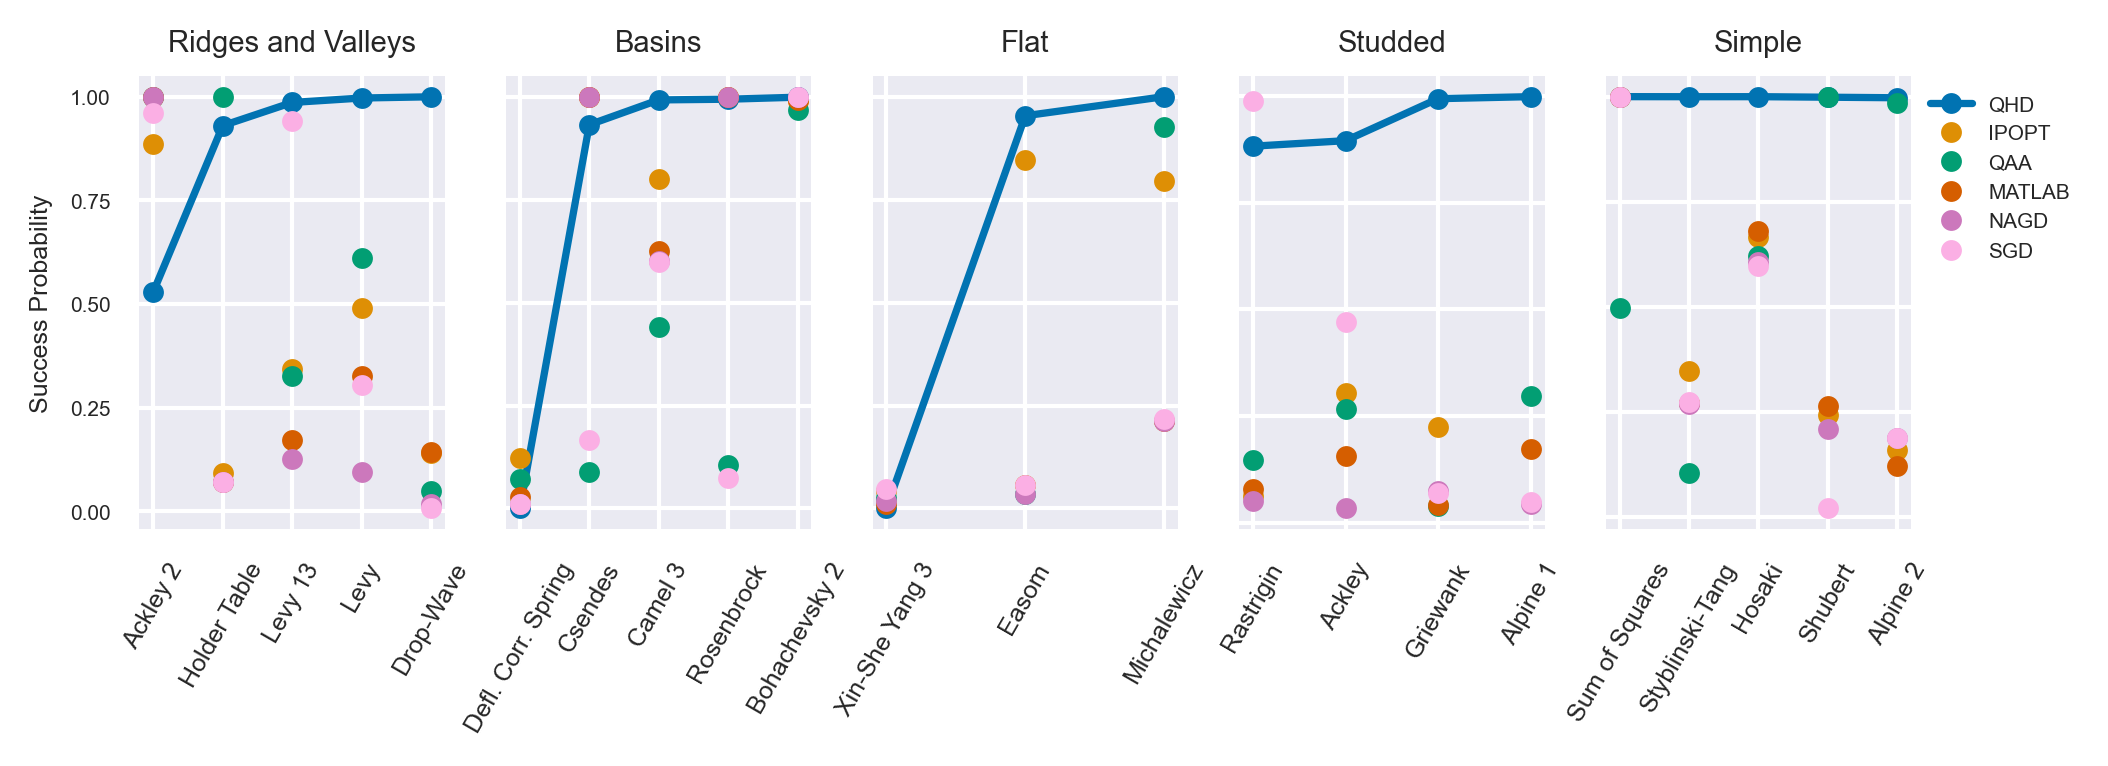

In [11]:
# CATEGORY PLOT of methods across instances separated by instance types
which_to_plot = ["QHD", "IPOPT", "QAA", "MATLAB", "NAGD", "SGD",]

MARKER_SIZE = 5

CATTITLE_SIZE = 7
YLABEL_SIZE = 6
YTICKLABEL_SIZE = 5
XTICKLABEL_SIZE = 6
LEGEND_SIZE = 5

cmap = sns.color_palette("colorblind")
# cmap = cmap[:5] + cmap[8:]
cmap = cmap[:5] + cmap[6:] 

f, ax = plt.subplots(1, 5, figsize=(150/25.4, 2), dpi=300)
plt.subplots_adjust(left=0.0, right=1)

for method_idx in range(len(which_to_plot)):
    method = which_to_plot[method_idx]
    ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[0].set_ylabel("Success Probability", size=YLABEL_SIZE)
    for category_idx in range(len(list(features.keys()))):
        category = list(features.keys())[category_idx]
        X = list(range(len(features[category])))
        Y = [prob_df[method][dirs.index(fn)] for fn in features[category]]

        # Only connect QHD markers
        linestyle = ""
        if method == "QHD":
            linestyle = "-"

        ax[category_idx].plot(X, Y, color=cmap[method_idx], marker="o", markersize=MARKER_SIZE, linestyle=linestyle, label=method)
        
        if category_idx > 0:
            ax[category_idx].set_yticklabels([])
        
        ax[category_idx].set_title(category, fontsize=CATTITLE_SIZE)
        
        ax[category_idx].set_xticks(list(range(len(X))))
        xlabels = [fname_to_label[fn] for fn in features[category]]
        ax[category_idx].set_xticklabels(xlabels, rotation=60,)
        ax[category_idx].tick_params(axis='x', which='major', labelsize=XTICKLABEL_SIZE)


# plt.suptitle("Success Probability Across Instance Categories")
ax[0].tick_params(axis='y', which='major', labelsize=YTICKLABEL_SIZE)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': LEGEND_SIZE})

plt.savefig("SuccessProb2D.eps", bbox_inches='tight')
plt.show()